In [66]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyesg 
import  evaluation as eval
import preproccessing as prep 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [353]:
acwi_prices = pd.read_excel('msci_acwi_net_30.10.23.xlsx')
acwi_prices.index = pd.DatetimeIndex(acwi_prices['Date'])
acwi_prices = acwi_prices['ACWI Standard Net (Large+Mid Cap)']
acwi_returns = prep.log_returns(acwi_prices)

<AxesSubplot:xlabel='Date'>

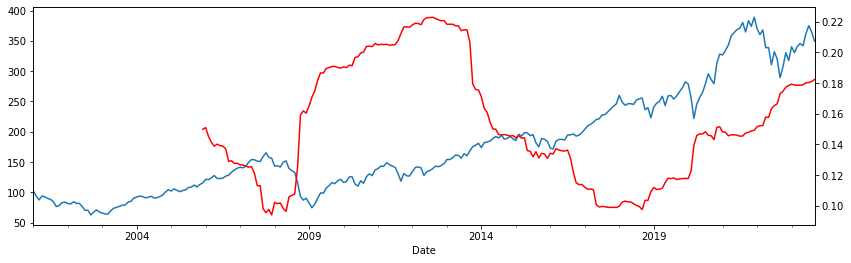

In [357]:
fig, ax1 = plt.subplots()
acwi_prices.plot(ax=ax1, figsize=(14,4))
ax2 = ax1.twinx()
(acwi_returns.rolling(60).std()*np.sqrt(12)).plot(ax=ax2, colormap='autumn')

In [361]:
def asset_stats(returns, periods):
    summary = []

    for period in periods:
        summary.append(prep.assets_performance(acwi_returns[period[0]:period[1]]))

    return pd.DataFrame(data=summary, index=periods)

periods = [('2001-01-31', '2023-09-30'),
           ('2001-01-31', '2019-12-31'), 
           ('2000-08-31', '2023-07-31'),
           ('2003-03-31', '2020-03-31'),
           ('2003-03-31', '2022-12-31'),
           ('2009-02-28', '2022-12-31'),
           ('2007-10-31', '2022-12-31'),
           ('2007-10-31', '2015-05-30')
           ]


asset_stats(acwi_returns,periods)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(2001-01-31, 2023-09-30)",0.055009,0.160995,-0.856140,2.121958,0.538119,-0.549231
"(2001-01-31, 2019-12-31)",0.054624,0.154934,-0.987229,2.835527,0.550549,-0.549231
"(2000-08-31, 2023-07-31)",0.058540,0.161136,-0.874261,2.159978,0.613556,-0.549231
"(2003-03-31, 2020-03-31)",0.072407,0.154143,-1.182134,3.763084,0.953037,-0.549231
"(2003-03-31, 2022-12-31)",0.080425,0.157982,-0.983730,2.908463,1.105673,-0.549231
"(2009-02-28, 2022-12-31)",0.104803,0.154169,-0.435559,0.801444,1.680774,-0.256253
"(2007-10-31, 2022-12-31)",0.045327,0.172403,-0.860163,2.140233,0.307968,-0.549231
"(2007-10-31, 2015-05-30)",0.028687,0.187189,-1.004988,2.562275,-0.024306,-0.549231


<AxesSubplot:xlabel='ACWI Standard Net (Large+Mid Cap)', ylabel='Count'>

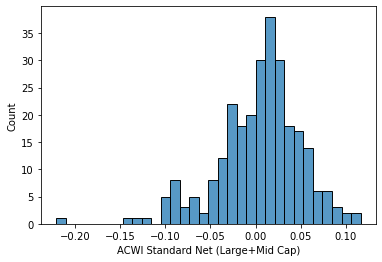

In [362]:
sns.histplot(data=acwi_returns, bins=32)

In [363]:
gbm_std = 0.155
gbm_mean = 0.5*gbm_std**2 + 0.072
gbm_mean

0.08401249999999999

In [404]:

model = pyesg.GeometricBrownianMotion(mu=0.072,sigma=0.155)
scenarios = model.scenarios(349,1,1000,50)

In [405]:
perc = np.percentile(scenarios,[1,5,25,50,75,95,99],axis=0)
#fanchart(None, perc)

def percentile_summary(perc):
    perc_dict = {'perc': ['1','5','25','50','75','95','99'],
                 '1': perc[:,1],
                 '2': perc[:,2],
                 '3': perc[:,3],
                 '5': perc[:,5],
                 '10': perc[:,10],
                 '15': perc[:,15],
                 '20': perc[:,20],
                 '50': perc[:,50]
                 }
    
    perc_summary = pd.DataFrame(perc_dict)
    perc_summary.set_index('perc', inplace=True)
    return perc_summary
percentile_summary(perc)

,1,2,3,5,10,15,20,50
perc,,,,,,,,
1,252.825045,230.803567,223.518830,216.511954,215.191453,221.098937,235.437903,379.756762
5,287.633090,281.585259,270.024827,273.156630,289.575251,306.115321,357.525259,1137.510431
25,333.723580,345.600770,354.291648,376.650382,452.184751,568.866377,736.733603,3423.390180
50,372.575200,395.026261,423.983852,469.471083,629.503973,859.294890,1176.136569,7350.542700
75,412.368315,453.651417,501.555970,604.001191,877.449905,1316.102061,1915.756805,14639.481750
95,477.286000,559.694614,646.754706,835.524333,1480.979559,2433.103737,3855.610233,38146.243437
99,527.750937,620.090257,739.776504,1008.232523,2097.055198,4206.484483,6223.565969,83081.551604


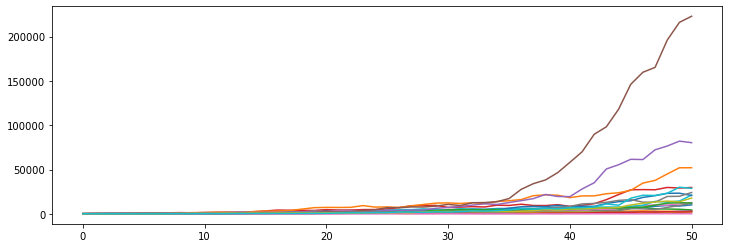

In [406]:
eval.sample_paths(scenarios,20)

In [408]:
scenarios_df = pd.DataFrame(data=scenarios, index=range(0,1000), columns=range(0,51))
scenarios_returns = prep.log_returns(scenarios_df.T)
display(eval.describe_scenarios_vertically(scenarios_returns, data_freq='y'))


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\matsz\AppData\Local\Temp\ipykernel_74944\365436379.py", line 3, in <cell line: 3>
    display(eval.describe_scenarios_vertically(scenarios_returns, data_freq='y'))
  File "c:\Users\matsz\programowanie\Optymalizacja portfela\esg\evaluation.py", line 41, in describe_scenarios_vertically
    return assets_performance(scenarios, data_freq).T.describe()
  File "c:\Users\matsz\programowanie\Optymalizacja portfela\esg\preproccessing.py", line 78, in assets_performance
    return returns.agg(func)
  File "c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\pandas\core\frame.py", line 8649, in aggregate
    result = op.agg()
  File "c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\pandas\core\apply.py", line 739,

In [409]:
eval.percentile_summary(scenarios_df)

,1,2,3,5,10,15,20,50
1,252.825045,230.803567,223.518830,216.511954,215.191453,221.098937,235.437903,379.756762
5,287.633090,281.585259,270.024827,273.156630,289.575251,306.115321,357.525259,1137.510431
25,333.723580,345.600770,354.291648,376.650382,452.184751,568.866377,736.733603,3423.390180
50,372.575200,395.026261,423.983852,469.471083,629.503973,859.294890,1176.136569,7350.542700
75,412.368315,453.651417,501.555970,604.001191,877.449905,1316.102061,1915.756805,14639.481750
95,477.286000,559.694614,646.754706,835.524333,1480.979559,2433.103737,3855.610233,38146.243437
99,527.750937,620.090257,739.776504,1008.232523,2097.055198,4206.484483,6223.565969,83081.551604


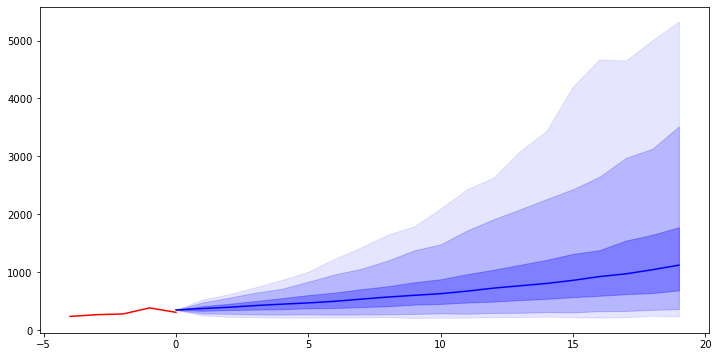

In [413]:
eval.fanchart(acwi_prices[-60::12],scenarios[:,:20])

<AxesSubplot:ylabel='Probability'>

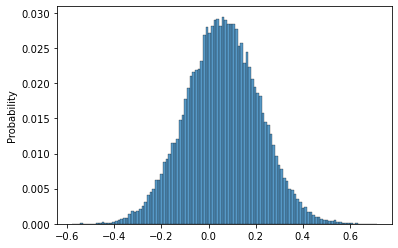

In [415]:
sns.histplot((scenarios_returns.to_numpy()).reshape(50000),stat='probability')

In [417]:
from scipy.stats import invgamma
T = 60 #acwi_returns.shape[0]
mu = acwi_returns.mean()
B = (((acwi_returns - mu)**2).sum())*0.5
a = (T/2+1)
mean = B/(a-1)
s = invgamma.rvs(a, loc=mean,scale=B,size=100)**0.5 *np.sqrt(12)
